In [1]:
import os, sys, time, copy, math
import random
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt

import multiprocessing
from functools import partial
from tqdm import tqdm

import collections
from typing import List
import bisect
import myokit
sys.path.append('../../../')
sys.path.append('../../../Protocols')
sys.path.append('../../../Models')
sys.path.append('../../../Lib')
import mod_protocols
import protocol_lib
import mod_trace
from preprocessing_lib import get_modified_current, get_currents_with_constant_dt 

import simulator_myokit
import simulator_scipy
import vc_protocols

In [2]:
def create_folder(path):
    if not os.path.exists(path):
        os.makedirs(path)
        print('"%s" has been created.'%(path))
    else:
        print("The folder already exists.")

In [3]:
create_folder("./fft_results")

The folder already exists.


In [4]:
a = 77000/3
print(a)
np.sqrt(a)

25666.666666666668


160.20819787597222

In [5]:
def inv_fast_fourier_transform(fft_y, f0, times, indices):
   
    nfft = len(times)  # number of sample count.  
    k = np.arange(nfft)      
    # recover      
        
    len_indices = len(indices)
    freq = f0[indices] #f0[idxy[i]]  
    yx = fft_y[indices] #fft_y[idxy[i]]  
    coec = yx.real  
    coes = yx.imag * -1
    
    freq = freq.reshape(len_indices,1) 
    coec = coec.reshape(len_indices,1)
    coes = coes.reshape(len_indices,1)
    times = times.reshape(1, nfft)
        
    freq_times = 2.0 * np.pi * freq * times
    newy = coec * np.cos(2 * np.pi * freq * times) + coes * np.sin(2 * np.pi * freq * times) 
    newy = newy.sum(axis=0)
      
    return newy

def get_certain_range_ifft(fft_y, len_data, range=(1, 2) ):   
    if range[0]==0 and range[1]==1:
        return np.fft.ifft(fft_y[:1], n=len_data)*len_data   # [0, 1,3,4,5,6,11, 12, 13, 17]        
    ifft = np.fft.ifft(fft_y[:range[1]], n=len_data)*len_data   # [0, 1,3,4,5,6,11, 12, 13, 17]
    ifft2 = np.fft.ifft(fft_y[:range[0]], n=len_data)*len_data   # [0, 1,3,4,5,6,11, 12, 13, 17]          
    return ifft - ifft2

### Get experimental dataset

In [6]:
params_test = {    
    't_eval' : None,  # times = np.linspace(0, 15.4, 77000)
    'log_li' : ['ikr.IKr', 'ikr.open', 'ikr.active'],
    'save_log_li' : ['ikr.IKr'],                               
    'dataset_dir' : f'../../../../Dataset/herg25oc1_real_data',
    'data_file_name' : 'IKr',
    'window' : 0.1,
    'step_size' : 0.05,
    'window_type' : 'avg'
}  
# sim_params['dataset_dir'] = sim_params['dataset_dir'] + f"_w{sim_params['window']}_s{sim_params['step_size']}"
print( params_test['dataset_dir'] )


'''
get raw dataset
'''
sys.path.append(params_test['dataset_dir'])
from getdata import get_dataset, get_times

cell_to_remove=['A04', 'A15', 'E05', 'E22', 'G10', 'G22', 'H08', 'I10', 'I12', 'I16', 'L08', 'P15', 'P18' ] # M24
cell_to_remove=[]

xs, ys, cells = get_dataset(cell_to_remove=cell_to_remove, scale=50, multi=True, torch_tensor=False)  # <-- fast
params_test['t_eval'] = get_times(scale=50)
print(xs.shape, ys.shape, params_test['t_eval'].shape)

../../../../Dataset/herg25oc1_real_data
The number of full cells : 211
The number of removed Cells : 0
The number of cells : 211
(211, 1540) (211, 9) (1540,)


### Voltage protocol (leak_staircase)

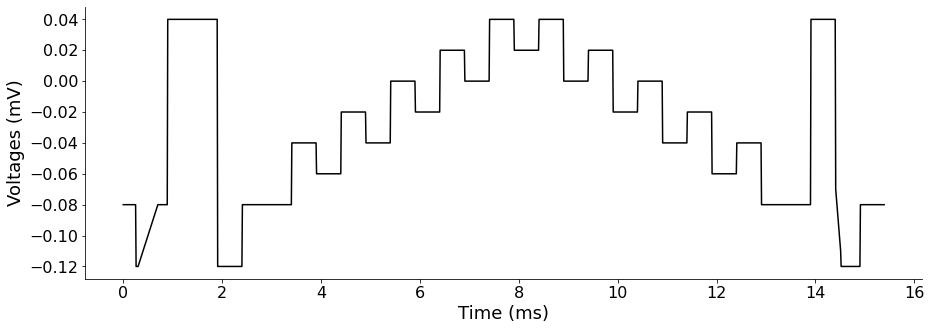

The protocol is 15.4 s


In [8]:
# VC_protocol = vc_protocols_for_myokit.leak_staircase()
VC_protocol = vc_protocols.leak_staircase()
VC_protocol.plot_voltage_clamp_protocol(params_test['t_eval'])
print(f'The protocol is {VC_protocol.get_voltage_change_endpoints()[-1]} s')

### Check std of noise for experimental data

In [9]:
check_range = 500

std_li = []
for x in xs:    
    std_li.append(np.std(x[:check_range]))
std_li = np.array(std_li)
std_avg = std_li.mean()
std_min = std_li.min()
std_max = std_li.max()
std_argmax = std_li.argmax()
std_argmin = std_li.argmin()
print(f"min: {std_min}  |  max: {std_max}  |  avg: {std_avg}")

min: 16.287210488503835  |  max: 360.0753317910074  |  avg: 108.57090435686354


### Modify experimental current

In [10]:
# params_noiseremoval = {
#     'time' : times,
#     'vc' : VC_protocol,
#     'neighbor_radius' : 5,
#     'method' : 1
# }

# start_time = time.time()

# pool = multiprocessing.Pool(processes=os.cpu_count())
# func = partial(get_modified_current, params_noiseremoval)
# modified_currents = pool.map(func, xs)
# pool.close()
# pool.join()

# print("--- %s seconds ---"%(time.time()-start_time))

In [11]:
# modified_currents = np.array(modified_currents)
# modified_currents.shape

### Simulation setting

In [12]:
start_time = time.time()

# hERG model settings
temperature = 25.0
temperature += 273.15  # in K
fit_seed = '542811797'
withfcap = False

model, p, s = myokit.load("../../../mmt-model-files/kylie-2017-IKr.mmt")    
model.get('phys.T').set_rhs(temperature)
# Set concentration
model.get('potassium.Ko').set_rhs(float(4.0))
model.get('potassium.Ki').set_rhs(float(110.0))

sim = simulator_myokit.Simulator(model, VC_protocol, max_step=0.001, abs_tol=1e-12, rel_tol=1e-14, vhold=-80e-3)  # 1e-12, 1e-14  # 1e-08, 1e-10
sim.name = "kylie2017IKr"  

print("--- %s seconds ---"%(time.time()-start_time))

--- 2.4080631732940674 seconds ---


### Set data to test

In [76]:
test_index = 150
nCheck = 1540

dt = params_test['t_eval'][1] - params_test['t_eval'][0]
fft_save_dir = f"./data{test_index}_fft_results_fre"
# create_folder(fft_save_dir)

print("dt:", dt)
print(f"Cell: {cells[test_index]}")


'''
# Frequency
'''
freq = np.fft.fftfreq(params_test['t_eval'].size, d=dt)
# freq = np.fft.fftshift(freq)
# print(freq.shape)

check_li = list(np.arange(101))
remove_li = [8,9, 14, 17, 25, 26, 27, 28, 30, 31, 36, 41, 96, 100]
for i in remove_li :
    check_li.remove(i)
# print(check_li)


'''
Set parameters of ion channel
'''
model_params = {                    
    'ikr.g' : ys[test_index, 0],  # random.uniform(parameter_ranges[0][0], parameter_ranges[0][1]),
    'ikr.p1' : ys[test_index, 1],
    'ikr.p2' : ys[test_index, 2],
    'ikr.p3' : ys[test_index, 3],
    'ikr.p4' : ys[test_index, 4],
    'ikr.p5' : ys[test_index, 5],
    'ikr.p6' : ys[test_index, 6],
    'ikr.p7' : ys[test_index, 7],
    'ikr.p8' : ys[test_index, 8],                
} 
sim.set_simulation_params(model_params)                

sim.pre_simulate(100, sim_type=1)
d = sim.simulate( params_test['t_eval'][-1]+dt, log_times=params_test['t_eval'], extra_log=params_test['log_li'])                           

sim_result= {}
sim_result["time"] = d['engine.time']
sim_result["IKr"] = d['ikr.IKr'] #+ np.random.normal(0, 11 , d['ikr.IKr'].shape) # add noise
sim_result["window"] = np.array(get_currents_with_constant_dt(params_test, [sim_result["time"], sim_result["IKr"]]))
sim_result["open"] = d['ikr.open']
sim_result["active"] = d['ikr.open']
# sim_result["params"] = raw['params']
y_sim = np.fft.fft(sim_result["IKr"])/sim_result["time"].size   
# ifft_sim = np.fft.ifft(y_sim, n=len_data)*len_data   # [0, 1,3,4,5,6,11, 12, 13, 17]
# ifft_sim = get_certain_range_ifft(y_sim, len_data, (0, 1) )
amp_sim = abs(y_sim)  # 벡터(복소수) norm 측정. 신호 강도. 
idxy_sim = np.argsort(-amp_sim) 
sim_result["fft"] = inv_fast_fourier_transform(y_sim, freq, sim_result["time"], idxy_sim[:nCheck]    )  
sim_result["fft_window"] = np.array(get_currents_with_constant_dt(params_test, [sim_result["time"], sim_result["fft"]]))



'''
# results for raw data
'''
raw_result = {}
raw_result["time"] = params_test['t_eval']
raw_result["IKr"] = xs[test_index]
raw_result["window"] = get_currents_with_constant_dt(params_test, [raw_result["time"], raw_result['IKr']])
y_raw = np.fft.fft(raw_result["IKr"])/raw_result["time"].size 
# ifft_raw = np.fft.ifft(y_raw, n=len_data)*len_data   # [0, 1,3,4,5,6,11, 12, 13, 17]
amp_raw = abs(y_raw)  # 벡터(복소수) norm 측정. 신호 강도. 
idxy_raw = np.argsort(-amp_raw) 
raw_result["fft"] = inv_fast_fourier_transform(y_raw, freq, raw_result["time"], idxy_raw[:nCheck]    )  # idxy_raw[:nCheck]    check_li[i
raw_result["fft_window"] = get_currents_with_constant_dt(params_test, [raw_result["time"], raw_result["fft"]])


# test_modified = modified_currents[test_index]
print(sim_result["IKr"].shape, sim_result["window"].shape, sim_result["fft_window"].shape)

dt: 0.01
Cell: K20
(1540,) (306,) (306,)


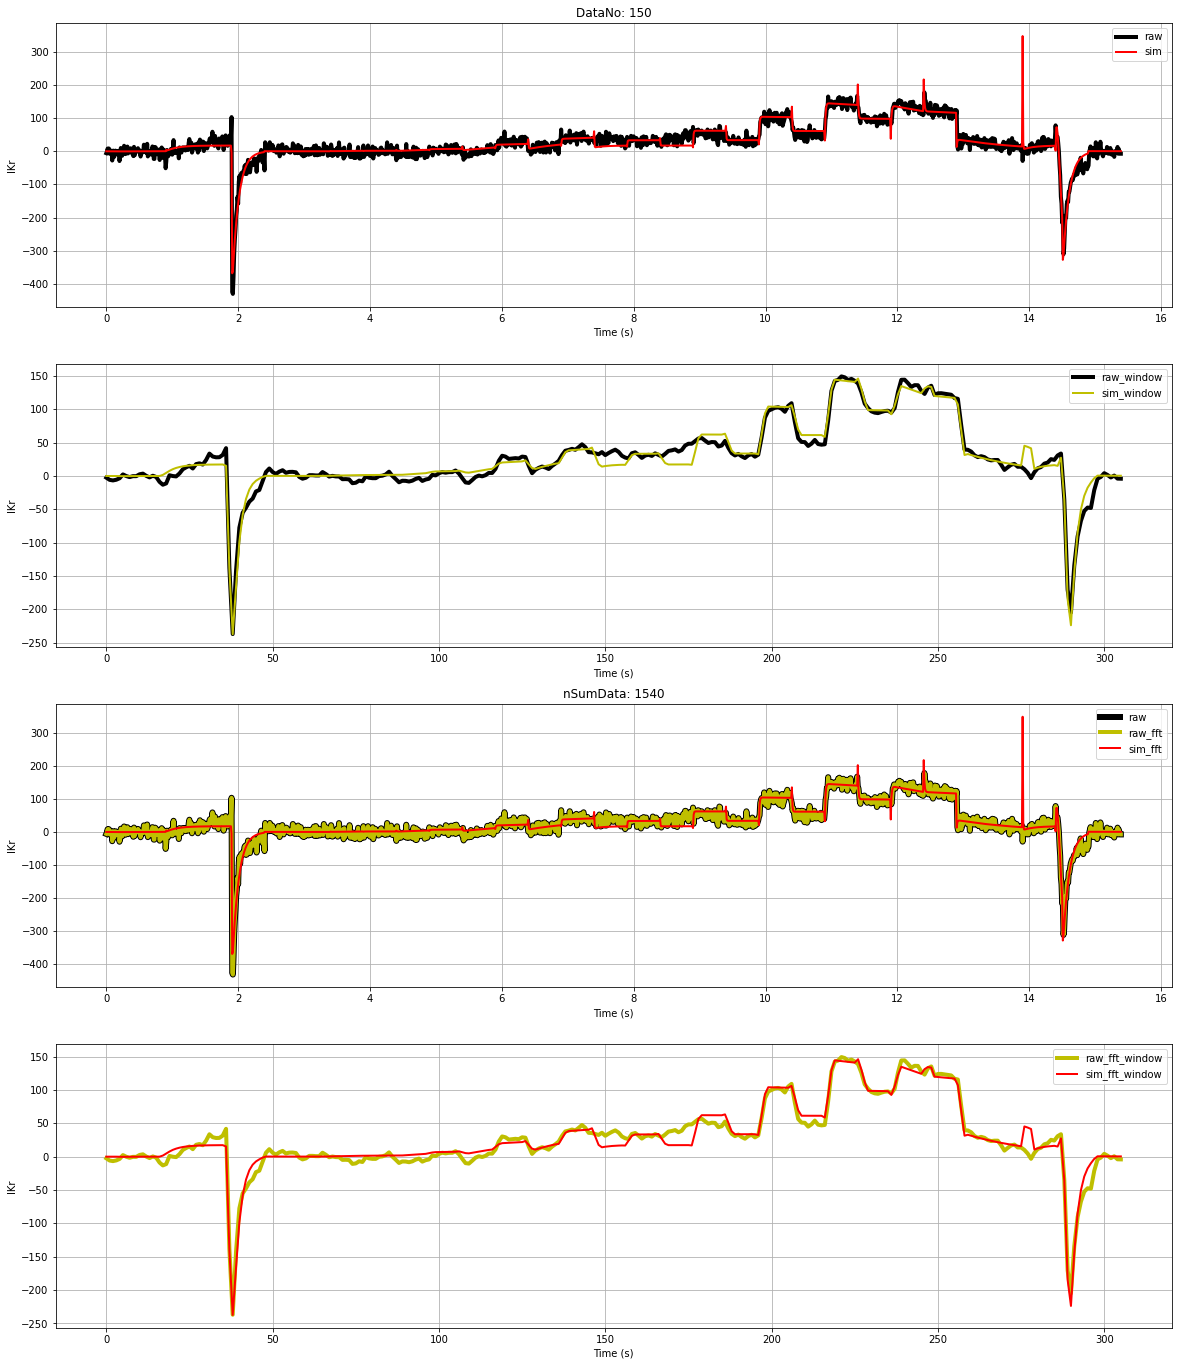

In [77]:
'''
Plot
'''
fig, ax = plt.subplots(4,1, figsize=(20,24))     

ax[0].set_title(f"DataNo: {test_index}")
ax[0].set_xlabel('Time (s)')    
ax[0].set_ylabel(f'IKr')      
# ax.set_xlim(1.5, 3)
ax[0].plot(raw_result["time"], raw_result["IKr"], c='k', label='raw', linewidth=4)  
ax[0].plot(sim_result["time"], sim_result["IKr"], c='r', label='sim', linewidth=2)  
ax[0].legend()
ax[0].grid()


# ax[1].set_title(f"DataNo: {test_index}  |  nSumData: {nCheck}")
ax[1].set_xlabel('Time (s)')    
ax[1].set_ylabel(f'IKr')      
# ax.set_xlim(1.5, 3)
ax[1].plot(raw_result["window"], c='k', label='raw_window', linewidth=4)  
ax[1].plot(sim_result["window"], c='y', label='sim_window', linewidth=2)  
ax[1].legend()
ax[1].grid()



ax[2].set_title(f"nSumData: {nCheck}")
ax[2].set_xlabel('Time (s)')    
ax[2].set_ylabel(f'IKr')      
# ax.set_xlim(1.5, 3)
ax[2].plot(raw_result['time'], raw_result['IKr']  , c='k', label='raw', linewidth=6)  
# ax.plot(sim_result["time"], sim_result["IKr"], c='b', label='ori_sim', linewidth=6)  
ax[2].plot(raw_result['time'], raw_result["fft"], c='y', label='raw_fft', linewidth=4)  
ax[2].plot(sim_result["time"], sim_result["fft"], c='r', label='sim_fft', linewidth=2)  
ax[2].legend()
ax[2].grid()

# ax[3].set_title(f"DataNo: {test_index}  |  nSumData: {nCheck}")
ax[3].set_xlabel('Time (s)')    
ax[3].set_ylabel(f'IKr')      
# ax.set_xlim(1.5, 3)
# ax.plot(sim_result["time"], sim_result["IKr"], c='b', label='ori_sim', linewidth=6)  
ax[3].plot(raw_result["fft_window"], c='y', label='raw_fft_window', linewidth=4)  
ax[3].plot(sim_result["fft_window"], c='r', label='sim_fft_window', linewidth=2)  
ax[3].legend()
ax[3].grid()

# fig.savefig(os.path.join('./fft_results_fre', f"{topn[0]}.jpg"), dpi=100)        
plt.show()

In [78]:
test_index = 150
nCheck = 500


dt = params_test['t_eval'][1] - params_test['t_eval'][0]
fft_save_dir = f"./data{test_index}_fft_results_fre"
# create_folder(fft_save_dir)

print("dt:", dt)
print(f"Cell: {cells[test_index]}")


'''
# Frequency
'''
freq = np.fft.fftfreq(params_test['t_eval'].size, d=dt)
# freq = np.fft.fftshift(freq)
# print(freq.shape)

check_li = list(np.arange(101))
remove_li = [8,9, 14, 17, 25, 26, 27, 28, 30, 31, 36, 41, 96, 100]
for i in remove_li :
    check_li.remove(i)
# print(check_li)

# test_modified = modified_currents[test_index]


'''
# results for raw data
'''
raw_result = {}
raw_result["time"] = params_test['t_eval']
raw_result["IKr"] = xs[test_index]
raw_result["window"] = get_currents_with_constant_dt(params_test, [raw_result["time"], raw_result['IKr']])
y_raw0 = np.fft.fft(raw_result["IKr"])/raw_result["time"].size 
# ifft_raw = np.fft.ifft(y_raw, n=len_data)*len_data   # [0, 1,3,4,5,6,11, 12, 13, 17]
amp_raw = abs(y_raw)  # 벡터(복소수) norm 측정. 신호 강도. 
idxy_raw = np.argsort(-amp_raw) 
raw_result["fft"] = inv_fast_fourier_transform( y_raw, freq, raw_result["time"], idxy_raw[:nCheck] )  # idxy_raw[:nCheck]    check_li
# raw_result["fft"] = inv_fast_fourier_transform(y_raw, freq, raw_result["time"], np.concatenate([idxy_raw[:nCheck], idxy_sim[nCheck:]])    )  # idxy_raw[:nCheck]    check_li
raw_result["fft_window"] = get_currents_with_constant_dt(params_test, [raw_result["time"], raw_result["fft"]])



dt: 0.01
Cell: K20


In [79]:
test_index = 152
nCheck = 1540

dt = params_test['t_eval'][1] - params_test['t_eval'][0]
fft_save_dir = f"./data{test_index}_fft_results_fre"
# create_folder(fft_save_dir)

print("dt:", dt)
print(f"Cell: {cells[test_index]}")


'''
# Frequency
'''
freq = np.fft.fftfreq(params_test['t_eval'].size, d=dt)
# freq = np.fft.fftshift(freq)
# print(freq.shape)

check_li = list(np.arange(101))
remove_li = [8,9, 14, 17, 25, 26, 27, 28, 30, 31, 36, 41, 96, 100]
for i in remove_li :
    check_li.remove(i)
# print(check_li)


'''
Set parameters of ion channel
'''
model_params = {                    
    'ikr.g' : ys[test_index, 0],  # random.uniform(parameter_ranges[0][0], parameter_ranges[0][1]),
    'ikr.p1' : ys[test_index, 1],
    'ikr.p2' : ys[test_index, 2],
    'ikr.p3' : ys[test_index, 3],
    'ikr.p4' : ys[test_index, 4],
    'ikr.p5' : ys[test_index, 5],
    'ikr.p6' : ys[test_index, 6],
    'ikr.p7' : ys[test_index, 7],
    'ikr.p8' : ys[test_index, 8],                
} 
sim.set_simulation_params(model_params)                

sim.pre_simulate(100, sim_type=1)
d = sim.simulate( params_test['t_eval'][-1]+dt, log_times=params_test['t_eval'], extra_log=params_test['log_li'])                           

sim_result= {}
sim_result["time"] = d['engine.time']
sim_result["IKr"] = d['ikr.IKr'] #+ np.random.normal(0, 11 , d['ikr.IKr'].shape) # add noise
sim_result["window"] = np.array(get_currents_with_constant_dt(params_test, [sim_result["time"], sim_result["IKr"]]))
sim_result["open"] = d['ikr.open']
sim_result["active"] = d['ikr.open']
# sim_result["params"] = raw['params']
y_sim = np.fft.fft(sim_result["IKr"])/sim_result["time"].size   
# ifft_sim = np.fft.ifft(y_sim, n=len_data)*len_data   # [0, 1,3,4,5,6,11, 12, 13, 17]
# ifft_sim = get_certain_range_ifft(y_sim, len_data, (0, 1) )
amp_sim = abs(y_sim)  # 벡터(복소수) norm 측정. 신호 강도. 
idxy_sim = np.argsort(-amp_sim) 
sim_result["fft"] = inv_fast_fourier_transform(y_sim, freq, sim_result["time"], idxy_sim[:nCheck]    )  
sim_result["fft_window"] = np.array(get_currents_with_constant_dt(params_test, [sim_result["time"], sim_result["fft"]]))



'''
# results for raw data
'''
raw_result = {}
raw_result["time"] = params_test['t_eval']
raw_result["IKr"] = xs[test_index]
raw_result["window"] = get_currents_with_constant_dt(params_test, [raw_result["time"], raw_result['IKr']])
y_raw = np.fft.fft(raw_result["IKr"])/raw_result["time"].size 
# ifft_raw = np.fft.ifft(y_raw, n=len_data)*len_data   # [0, 1,3,4,5,6,11, 12, 13, 17]
amp_raw = abs(y_raw)  # 벡터(복소수) norm 측정. 신호 강도. 
idxy_raw = np.argsort(-amp_raw) 
raw_result["fft"] = inv_fast_fourier_transform(np.concatenate([y_raw[idxy_sim[:nCheck]], y_raw[idxy_sim[nCheck:]]]), freq, raw_result["time"], idxy_raw[:nCheck]    )  # idxy_raw[:nCheck]    check_li[i
raw_result["fft_window"] = get_currents_with_constant_dt(params_test, [raw_result["time"], raw_result["fft"]])


# test_modified = modified_currents[test_index]
print(sim_result["IKr"].shape, sim_result["window"].shape, sim_result["fft_window"].shape)

dt: 0.01
Cell: K24
(1540,) (306,) (306,)


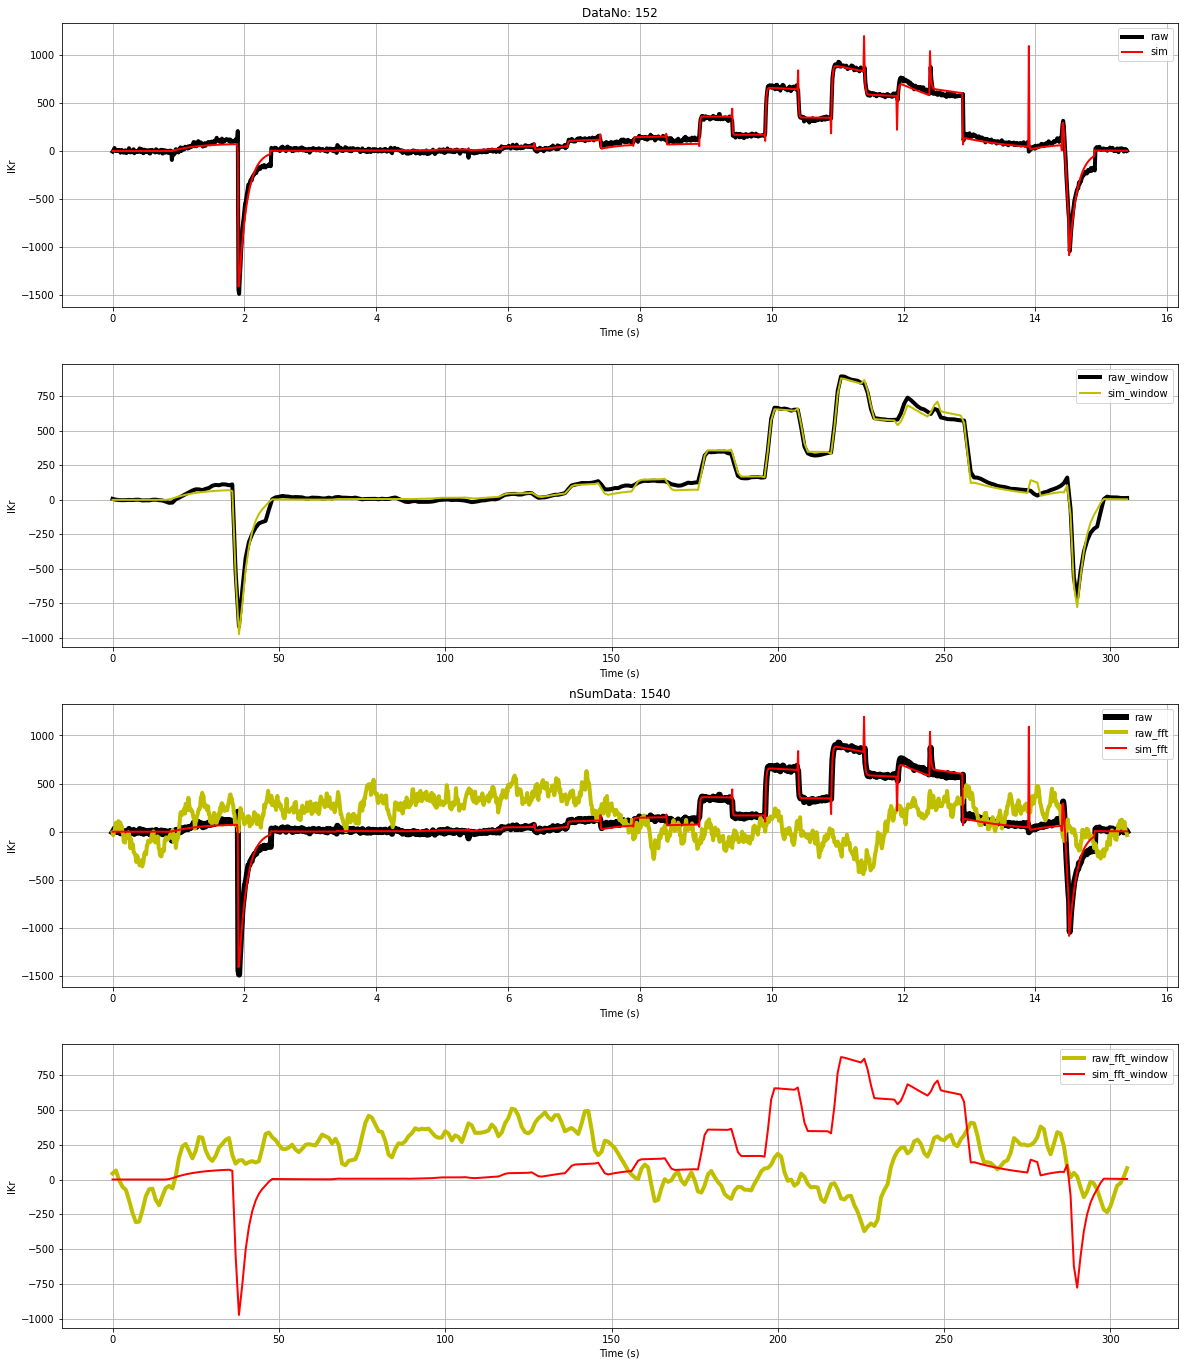

In [80]:
'''
Plot
'''
fig, ax = plt.subplots(4,1, figsize=(20,24))     

ax[0].set_title(f"DataNo: {test_index}")
ax[0].set_xlabel('Time (s)')    
ax[0].set_ylabel(f'IKr')      
# ax.set_xlim(1.5, 3)
ax[0].plot(raw_result["time"], raw_result["IKr"], c='k', label='raw', linewidth=4)  
ax[0].plot(sim_result["time"], sim_result["IKr"], c='r', label='sim', linewidth=2)  
ax[0].legend()
ax[0].grid()


# ax[1].set_title(f"DataNo: {test_index}  |  nSumData: {nCheck}")
ax[1].set_xlabel('Time (s)')    
ax[1].set_ylabel(f'IKr')      
# ax.set_xlim(1.5, 3)
ax[1].plot(raw_result["window"], c='k', label='raw_window', linewidth=4)  
ax[1].plot(sim_result["window"], c='y', label='sim_window', linewidth=2)  
ax[1].legend()
ax[1].grid()



ax[2].set_title(f"nSumData: {nCheck}")
ax[2].set_xlabel('Time (s)')    
ax[2].set_ylabel(f'IKr')      
# ax.set_xlim(1.5, 3)
ax[2].plot(raw_result['time'], raw_result['IKr']  , c='k', label='raw', linewidth=6)  
# ax.plot(sim_result["time"], sim_result["IKr"], c='b', label='ori_sim', linewidth=6)  
ax[2].plot(raw_result['time'], raw_result["fft"], c='y', label='raw_fft', linewidth=4)  
ax[2].plot(sim_result["time"], sim_result["fft"], c='r', label='sim_fft', linewidth=2)  
ax[2].legend()
ax[2].grid()

# ax[3].set_title(f"DataNo: {test_index}  |  nSumData: {nCheck}")
ax[3].set_xlabel('Time (s)')    
ax[3].set_ylabel(f'IKr')      
# ax.set_xlim(1.5, 3)
# ax.plot(sim_result["time"], sim_result["IKr"], c='b', label='ori_sim', linewidth=6)  
ax[3].plot(raw_result["fft_window"], c='y', label='raw_fft_window', linewidth=4)  
ax[3].plot(sim_result["fft_window"], c='r', label='sim_fft_window', linewidth=2)  
ax[3].legend()
ax[3].grid()

# fig.savefig(os.path.join('./fft_results_fre', f"{topn[0]}.jpg"), dpi=100)        
plt.show()

In [17]:
# a = np.arange(3).reshape(3,1)
# b = (2*np.ones(3)).reshape(3,1)
# tt = np.ones(6).reshape(1,6)
# cc = b* (a * tt)
# print(cc)
# cc = cc.sum(axis=0)
# cc

# vvv = np.arange(5)*10
# print(vvv)
# np.argsort(vvv)

In [18]:
# nCheck = 100
# indices = np.arange(nCheck)
# is_plot = False
# fs = 5000

# # amp, freq, fft_y = fast_fourier_transform(times, test_raw, fs=fs, is_plot=False)
# # ifft_raw = inv_fast_fourier_transform(fft_y, amp, freq, times, topn=topn)

# # print(sim_result["time"].shape, sim_result["IKr"].shape)
# amp, freq, fft_y = fast_fourier_transform(sim_result["time"], sim_result["IKr"], fs=fs, is_plot=True)
# ifft_sim_JK = inv_fast_fourier_transform(fft_y, freq, sim_result["time"], indices=indices)
# # ifft_sim = np.fft.ifft(fft_y[:nCheck], n=77000)*77000  # [0, 1,3,4,5,6,11, 12, 13, 17]
# print(ifft_sim_JK.shape)
# #     fft_raw = fast_fourier_transform(times, test_raw, topn=topn, fs=fs, is_plot=is_plot)
# #     fft_sim = fast_fourier_transform(sim_result["time"], sim_result["IKr"], topn=topn, fs=fs, is_plot=is_plot)

In [19]:
dt = 0.0002 # 1/fs   # 0.001  
fs = 10000

# 주파수 생성  
nfft = 2*len(times)  # number of sample count.  
# print('nfft = ', nfft)  
df = fs/nfft    # 주파수 증가량 = max freq / 샘플개수  
k = np.arange(nfft)  
f = k*df      # 0부터~최대주파수까지의 범위 (sample count 개수 만큼, df증가량으로 분포)  
# 주파수 스펙트럼은 중앙을 기준으로 대칭이 된다. 반만 구한다.  
nfft_half = math.trunc(nfft/2)  
f0 = f[range(nfft_half)]      # only half size check for get hz.  

'''
# Frequency
'''
freq = np.fft.fftfreq(test_raw.size, d=dt)
# freq = np.fft.fftshift(freq)
print(freq.shape)

for i in range(1):
    '''
    # fft for raw data
    '''
    y_raw = np.fft.fft(test_raw)/times.size 
    # ifft_raw = np.fft.ifft(y_raw[:], n=len_data)*len_data   # [0, 1,3,4,5,6,11, 12, 13, 17]
    amp_raw = abs(y_raw)  # 벡터(복소수) norm 측정. 신호 강도. 
    idxy_raw = np.argsort(-amp_raw) 
    ifft_raw = inv_fast_fourier_transform(y_raw, freq, times, [i])  # idxy_raw[:nCheck]    
    # print(idxy_raw)

    '''
    # fft for simulation data
    '''
    y_sim = np.fft.fft(sim_result["IKr"])/len_data   
#     ifft_sim = get_certain_range_ifft(y_sim, len_data, (i, i+1) )
    amp_sim = abs(y_sim)  # 벡터(복소수) norm 측정. 신호 강도. 
    idxy_sim = np.argsort(-amp_sim) 
    ifft_sim = inv_fast_fourier_transform(y_sim, freq, times, [i])  
    # print(idxy_sim)


    fig, ax = plt.subplots(1,1, figsize=(20,7))     
    ax.set_title(f"{i} - raw : {amp_raw[i]} | sim : {amp_sim[i]} | diff : {abs(amp_raw[i]-amp_sim[i])}")
    # ax.set_xlabel('Time (ms)')       
    # ax.set_ylabel(f'IKr')      
    # ax.plot(times, test_real  , c='k', label='orginal')  
    # ax.plot(times, test_raw  , c='k', label='orginal', linewidth=6)  
    ax.plot(times, ifft_raw, c='y', label='fft_raw', linewidth=3)  
    # ax.plot(sim_result["time"], sim_result["IKr"], c='b', label='ori_sim', linewidth=6)  
    ax.plot(sim_result["time"], ifft_sim.real, c='r', label='fft_sim', linewidth=3)  
    # ax.plot(sim_result["time"], ifft_sim_JK, c='r', label='fft_sim_JK', linewidth=1)
    ax.legend()
    ax.grid()
#     fig.savefig(os.path.join(fft_save_dir, f"{i}.jpg"), dpi=64)        
#     plt.show()
print("Finish")

NameError: name 'times' is not defined

In [ ]:
t = np.linspace(0, 1, 1000)
s1 = 2*np.sin(2*np.pi*10*t) 
s2 = np.sin(2*np.pi*20*t)
s3 = 0.5*np.sin(2*np.pi*30*t)
s4 = 1.5*np.sin(2*np.pi*40*t)

s = s1 + s2 + s3 + s4

nCheck = 5

check_li = np.arange(nCheck)
check_li = np.array([0,1,2, 3,4,5,6])
# check_li = check_li.reshape(check_li.shape[0], 1)
print(check_li.shape)

# amp, freq, fft_y = fast_fourier_transform(t, s, fs=1000, is_plot=False)
# ifft1 = inv_fast_fourier_transform(fft_y, amp, freq, t, topn=check_li)
# print(ifft1.shape)

len_data = len(t)
Y_raw = np.fft.fft(s)/len_data 
ifft2 = np.fft.ifft(Y_raw, n=1000)*len_data   # [0, 1,3,4,5,6,11, 12, 13, 17]
print(ifft2.shape)

freq = np.fft.fftfreq(s.size, d=0.001)
print(freq.shape)

Y_raw = scipy.fft.fft(s)/len_data 
ifft3 = scipy.fft.ifft(Y_raw, n=1000)*len_data   # [0, 1,3,4,5,6,11, 12, 13, 17]
print(ifft3.shape)

amp = abs(Y_raw)
# print(amp, amp)
# nfft = len(t)  # number of sample count.
# nfft_half = math.trunc(nfft/2)  
# # print(fft_s.shape)
# # f0 = f[range(nfft_half)]      # only half size check for get hz.  
# fft_s = np.fft.fft(s)/len(t) *2 
# print(fft_s.shape)
# y0 = fft_s[range(nfft_half)]       # one side.  
# print(y0.shape)
# amp = abs(y0)  # 벡터(복소수) norm 측정. 신호 강도. 
# idxy = np.argsort(-amp) 
# print(idxy.shape)
# # print(idxy[:10000])
# print(fft_s[10])
# print(idxy[:10])
# print(fft_s[idxy[:10]])
# ifft_s2 = np.fft.ifft(fft_s[idxy[:]])*len(t) /2

# plt.xlim(-100, 0)
plt.plot( freq, amp, label='freq')
plt.legend()
plt.show()

plt.xlim(0, 100)
# plt.ylim(0, 1200, 200)
# plt.plot(s, label='raw')
# plt.plot(t, ifft1, label='ifft1')
plt.plot(ifft2, label='ifft2')
plt.legend()
plt.show()